# Exploring Clustering Results
The file containing the clustering results is stored in the processed data folder with the suffix clean. The index is set to the first __Product group key__.

As a reminder the file is organized in three columns: _Product Group Key_, _Cluster Number_ and the corresponding _Centroid_ of the cluster.

In [200]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1


import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(os.getcwd(), os.pardir,os.pardir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)


from data import preprocessing as prp
%aimport data.preprocessing


import pandas as pd
import math
import numpy as np

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import copy as cp

import seaborn as sns

import statsmodels.api as sm
from scipy.stats import chisquare

from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())

subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)

file_name = "euc_p2_clustering_clean_week_v1.csv"

df_prd_cluster = pd.read_csv(models_path+file_name, sep=';', encoding='utf-8').drop('Unnamed: 0',axis=1).set_index('Product')

print(df_prd_cluster.shape)
df_prd_cluster.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1230, 2)


,Cluster,Centroid
Product,,
3250001070000,1,"('3250001070000',)"
3250001080000,2,"('3250001080000',)"
3250003060000,3,"('3250003060000',)"
3250066040000,37,"('3330135005600',)"
3250067030000,8,"('3258806000000',)"


## Get clients description

In [201]:
file_name = "client_7cerf.txt"

non_unique_features = []

unique_features = []


client_df = pd.read_csv(raw_path+file_name, sep='\t', encoding='utf-8').fillna("NA")
                    #.drop_duplicates()

    
#client_df.to_csv(raw_path+"client_7cerf.csv",sep=';',encoding='utf-8')
client_df.head()

,Key_lvl1,Description,Key_lvl2,Key_lvl3,Key_lvl4,Opening Date,City Level,Port Type,Operation State,Store Type,Store Level,Business Area,Store Style,Status
0,01257,NA,大英区域,四川分公司,Total,2012-04-16,Level 4,Residential Community,Opening as normal,Single-layer Store,Level E,150,First-generation,Active
1,01258,NA,广巴区域,四川分公司,Total,2012-05-12,Level 2,Residential Community,Opening as normal,Single-layer Store,Level C,95.94,First-generation,Active
2,01259,NA,什绵区域,四川分公司,Total,2012-05-06,Level 3,Residential Community,Opening as normal,Single-layer Store,Level E,140,First-generation,Active
3,01262,NA,广汉区域,四川分公司,Total,2012-06-05,Level 4,Residential Community,Opening as normal,Single-layer Store,Level D,240,Second-generation,Active
4,01264,NA,独立二区,四川分公司,Total,2012-06-01,Level 1,Residential Community,Opening as normal,Single-layer Store,Level B,180,Second-generation,Active


## Get Products description
In order to get the product features description, an inner join on the product group key is operated on the cluster result with the products description file.

Since the clustering was calculated on the second level group, some columns of the description file must be dropped in order to avoid duplicates of the first level products (mainly Promo and Standard version of the products)

In [202]:
file_name = "product_7cerf.txt"

non_unique_features=[]

code_features = []

unbalanced = ["Key_lvl2","Key_lvl7","Continuation of","Product Status",'Base Price 1 Coefficient Table',"Sales Season","Product ABC Classification"]

df_produit = pd.read_csv(raw_path+file_name, sep='\t',encoding="utf8")


                
# df_produit = df_produit.drop(code_features,axis=1)
# df_produit = df_produit.drop_duplicates()
#df_produit = df_produit.dropna(how="all")
# df_produit = df_produit.reset_index(drop=True)
# df_produit = df_produit.apply(lambda x:x.astype(str).str.upper())

df_produit = df_produit.drop(unbalanced,axis=1)
df_produit = df_produit.drop_duplicates(["Key_lvl1","Description"])



print(df_produit.shape)
df_produit.head()

(57409, 15)


,Key_lvl1,Description,Key_lvl3,Key_lvl4,Key_lvl5,Key_lvl6,Base Price 1 Target Value,Color,Size,Gender,Year of Commodity,Launch Date,Tag Price,Continuation,Age Group
0,20300138600,RQC-老人头棉袜BL0017,男-短袜-长筒袜-8.25元,男-短袜-长筒袜,男-短袜,男,8.0,No Color,JM,No Gender,2011,01/01/1900,8.25,NO,29-38
1,20300329000,RQC-国奥棉袜BL4038,男-短袜-长筒袜-4.38元,男-短袜-长筒袜,男-短袜,男,4.0,No Color,JM,No Gender,2011,01/01/1900,4.38,NO,29-38
2,20300355500,RQC-爱国者棉袜BL010,男-短袜-长筒袜-4.76元,男-短袜-长筒袜,男-短袜,男,5.0,No Color,JM,No Gender,2011,01/01/1900,4.76,NO,29-38
3,20300418700,RQC-老人头棉袜BL0020,男-短袜-长筒袜-8.25元,男-短袜-长筒袜,男-短袜,男,8.0,No Color,JM,No Gender,2011,01/01/1900,8.25,NO,29-38
4,20300419000,RQC-老人头棉袜BL0021,男-短袜-长筒袜-7.5元,男-短袜-长筒袜,男-短袜,男,8.0,No Color,JM,No Gender,2011,01/01/1900,7.50,NO,29-38


In [4]:
#Join with clusters
product_cluster = df_produit.join(df_prd_cluster,on='Key_lvl1',how='inner').reset_index(drop = True)
print(product_cluster.shape)
product_cluster.head()

#product_cluster.to_csv(interim_path+"product_cluster.csv",sep=";",encoding="utf-8")

(1230, 17)


,Key_lvl1,Description,Key_lvl3,Key_lvl4,Key_lvl5,Key_lvl6,Base Price 1 Target Value,Color,Size,Gender,Year of Commodity,Launch Date,Tag Price,Continuation,Age Group,Cluster,Centroid
0,3250001070000,RQC-伊士林短袜,女-短袜-隐形袜-10元,女-短袜-隐形袜,女-短袜,女,10.0,No Color,No Size,Female,2014,24/02/2014,10.0,NO,29-38,1,"('3250001070000',)"
1,3250001080000,RQC-伊士林短袜,女-短袜-隐形袜-9元,女-短袜-隐形袜,女-短袜,女,9.0,No Color,No Size,Female,2014,24/02/2014,9.0,NO,29-38,2,"('3250001080000',)"
2,3250003060000,RQC-伊士林短袜,女-短袜-船袜-9元,女-短袜-船袜,女-短袜,女,9.0,No Color,No Size,Female,2014,07/03/2014,9.0,NO,29-38,3,"('3250003060000',)"
3,3250066040000,RQC-伊士林短袜,女-短袜-隐形袜-10元,女-短袜-隐形袜,女-短袜,女,10.0,No Color,No Size,Female,2014,24/02/2014,10.0,NO,29-38,37,"('3330135005600',)"
4,3250067030000,RQC-伊士林短袜,女-短袜-隐形袜-10元,女-短袜-隐形袜,女-短袜,女,10.0,No Color,No Size,Female,2014,24/02/2014,10.0,NO,29-38,8,"('3258806000000',)"


## Translate Features

In [203]:
translations = prp.load_file("translations")

for index,col in translations.iteritems():
    product_cluster[index] = col


## Merge Products and Clients tables

Save the final result into a csv file for further exploration

In [174]:
filename = "p2_clustering_clean_week.csv"
product_cluster.to_csv(processed_path+filename,sep=';',encoding='utf-8')


# Homogeneity Test
In order to detect specific caraterstics for each resulted cluster we perform a statistic test based on Pearsons chi-square score with the hypothesis of a uniform distribution.

Features with the pvalues lower than 0.1 are displayed for analysis

In [102]:
def cramer_v(chisq,n,k,r=1):
    return math.sqrt(chisq/(n * min(k-1,r-1) ))

## Calculate modalities frequency through clusters
As a first step, all the distrubtions of modalities across features and clusters are calculated and stored in one array structered as follows:

One array for each cluster which contains a dictionnary of features. Each feature is again a dictionary of modalities and their occurence in that cluster

In [214]:
#get the features
all_features = product_cluster.columns[2:-2]


features = all_features

#get the clusters (actually its a range(1,nb_cluster))
clusters = set(product_cluster['Cluster'].values)

#array to store each cluster and freq for all the features
clusters_feature_dist = [0] #to shift the indices to clusters

#loop trhough features

for c in clusters:
    feature_dist = dict()
    for feature in features:
        freq = product_cluster[product_cluster['Cluster']==c].groupby(feature)[feature].count()
        feature_dist[feature]=freq.to_dict()
    clusters_feature_dist.append(feature_dist)



## Chi-square test over clusters

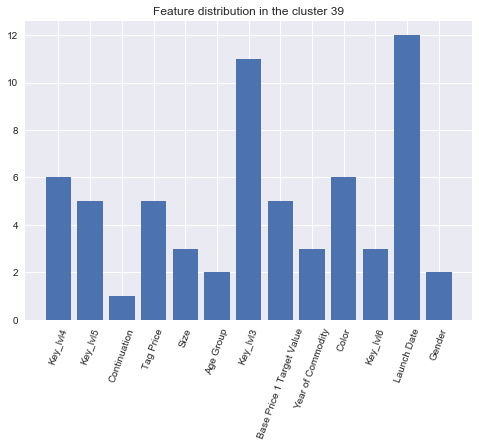

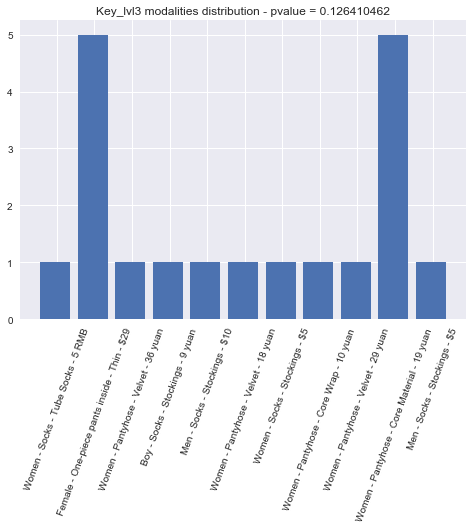

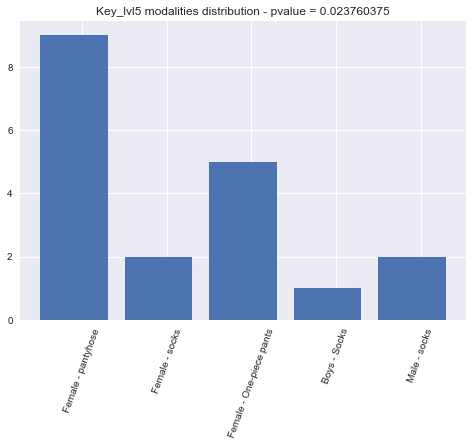

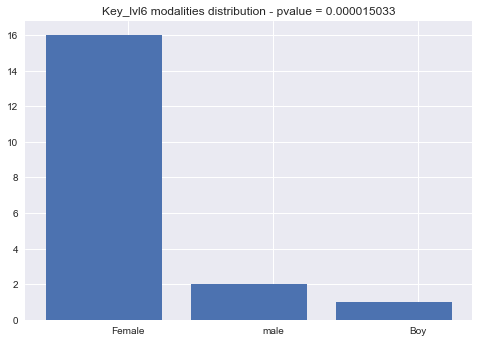

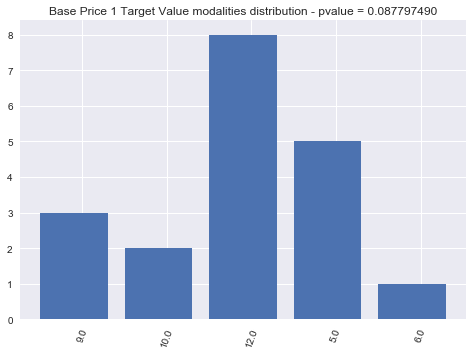

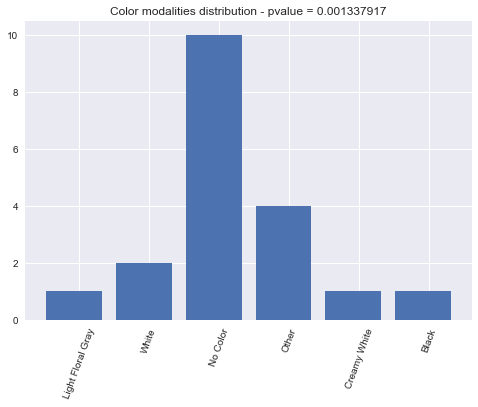

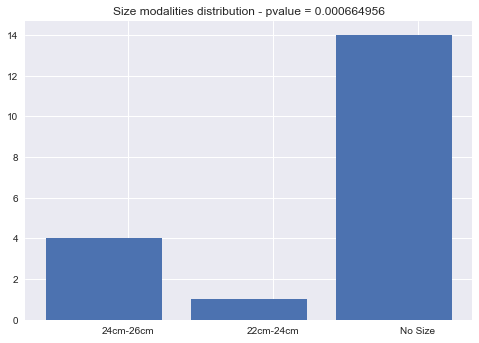

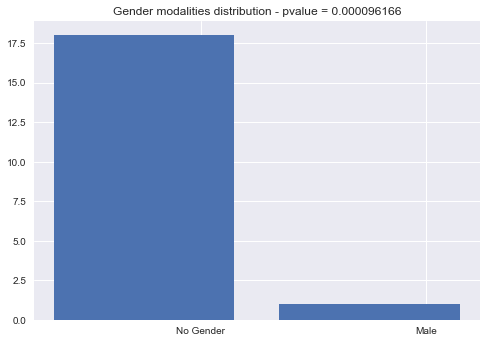

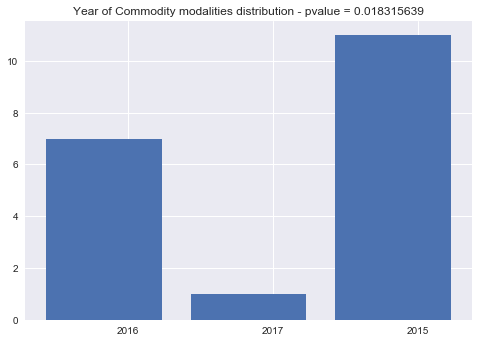

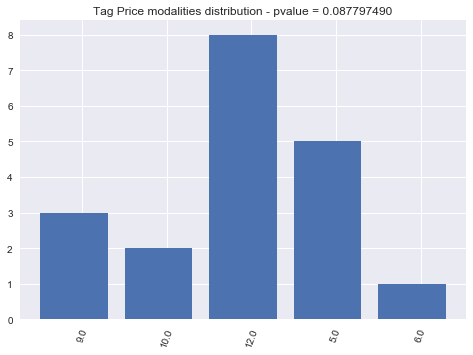

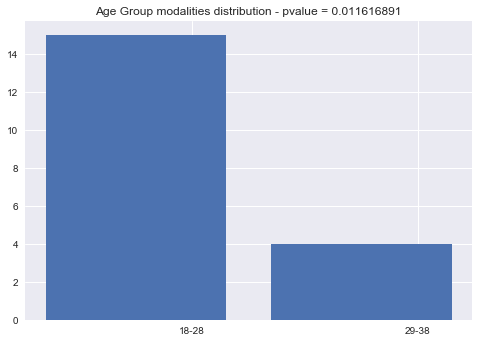

In [212]:

pthreashold = 0.2

#get the features
features = all_features

clusters = [39]


res_features_over_cluster = [0]
for c in clusters:
    #align each feature with its distrubtion in this cluster c
    cluster_feature_dist = clusters_feature_dist[c]
    dist = [len(x) for x in list(cluster_feature_dist.values())]
    keys = list(cluster_feature_dist.keys())    

    #plot the dist of number of elements by feature in this clust
    plt.title("Feature distribution in the cluster %d"%c)
    plt.bar(range(len(keys)),dist)
    plt.xticks(range(len(keys)),keys,rotation=70)
    
    #for each feature display its distribution over modalities
    for feature in features:
        #get information from the previous array
        cluster_feature_dist = clusters_feature_dist[c]
        feature_distribution = list(cluster_feature_dist[feature].values())
        feature_keys = list(cluster_feature_dist[feature].keys())
        nftrs = len(feature_keys)
        chisq, p = chisquare(feature_distribution)
        if p<pthreashold:
            plt.figure()
            plt.title("%s modalities distribution - pvalue = %.9f"%(feature,p))
            plt.bar(np.arange(nftrs),feature_distribution)
            plt.xticks(np.arange(nftrs)+(0.5/nftrs),feature_keys,rotation=70 if nftrs>4 else 0)
    plt.show(block = True)
    


## Calculate modalities frequency through features

In [215]:
#get the features
features = all_features

#get the clusters (actually its a range(1,nb_cluster))
clusters = set(product_cluster['Cluster'].values)

#dict to store each feater and freq for all the clusters
features_clust_dist = dict()

#invert the dict and get it by feature 
for f in features:
    freq = dict()
    for c in clusters: 
        freq[c] =  clusters_feature_dist[c][f]
    features_clust_dist[f] = freq

## Chi-square test over features

In [ ]:
pthreashold = 0.2
clusters = set(product_cluster['Cluster'].values)

features = all_features
features = ["Key_lvl3"]

for f in features:
    for c in clusters:
        #get information from the previous array
        feature_clust_dist = features_clust_dist[f]
        feature_distribution = list(feature_clust_dist[c].values())
        feature_keys = list(feature_clust_dist[c].keys())
        nftrs = len(feature_keys)
        chisq, p = chisquare(feature_distribution)
        if p<pthreashold:
            plt.figure()
            plt.title("%s: Cluster %d distribution - pvalue = %.9f"%(f,c,p))
            plt.bar(np.arange(nftrs),feature_distribution)
            plt.xticks(np.arange(nftrs)+(1.0/nftrs),feature_keys,rotation=70 if nftrs>5 else 0)
            
    plt.show(block = True)     



## Modalities distribution

In [216]:
clusters = set(product_cluster['Cluster'].values)
nclusters = len(clusters)
#get the features
features = all_features


modalities_clust_dist = dict()

for f in features:
    feature_sum=[]
    modalities = set(product_cluster[f].values)
    modalities_distribution=dict()
    for m in modalities:
        modality_distribution = np.zeros((nclusters+1))
        for c in clusters:
            #get information from the previous array
            feature_clust_dist = features_clust_dist[f]
            modality_distribution[c] +=(feature_clust_dist[c][m] if m in feature_clust_dist[c] else 0)
        modalities_distribution[m] = modality_distribution    
    modalities_clust_dist[f] = modalities_distribution 

## Chi-square test for modalities over clusters

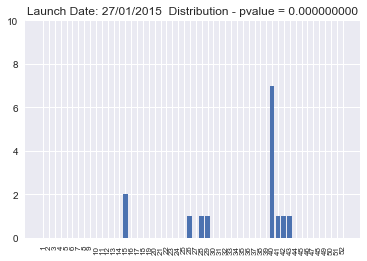

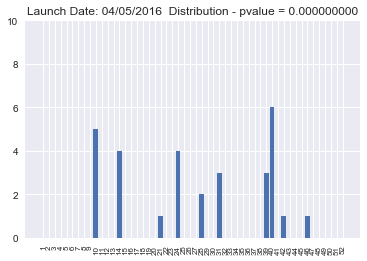

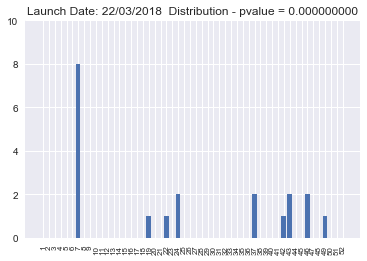

C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\scipy\stats\stats.py:4544: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [222]:
%matplotlib inline

clusters = set(product_cluster['Cluster'].values)
nclusters = len(clusters)


pthreashold = 0.2

n_min_dist = 10
min_members = 5


min_dust  = True
for f in features:
    modalities = set(product_cluster[f].values)
    r = len(modalities)
    for m in modalities:
        modality_dist = modalities_clust_dist[f][m]
        md = np.count_nonzero(modality_dist)<=n_min_dist and np.max(modality_dist)>min_members
        chisq, p = chisquare(modality_dist)
        if p<pthreashold and (md and min_dust):
            plt.figure()
            plt.title("%s: %s  Distribution - pvalue = %.9f"%(f,m,p))
            plt.bar(np.arange(nclusters)+1,modality_dist[1:])
            plt.xticks(np.arange(nclusters)+(1.0/nclusters)+1,np.arange(nclusters)+1,rotation=90,size=8)
            if np.max(modality_dist[1:])<10: plt.ylim(0,10)
    plt.show(block = True)  

## MCA Analysis

### Remove unbalanced columns

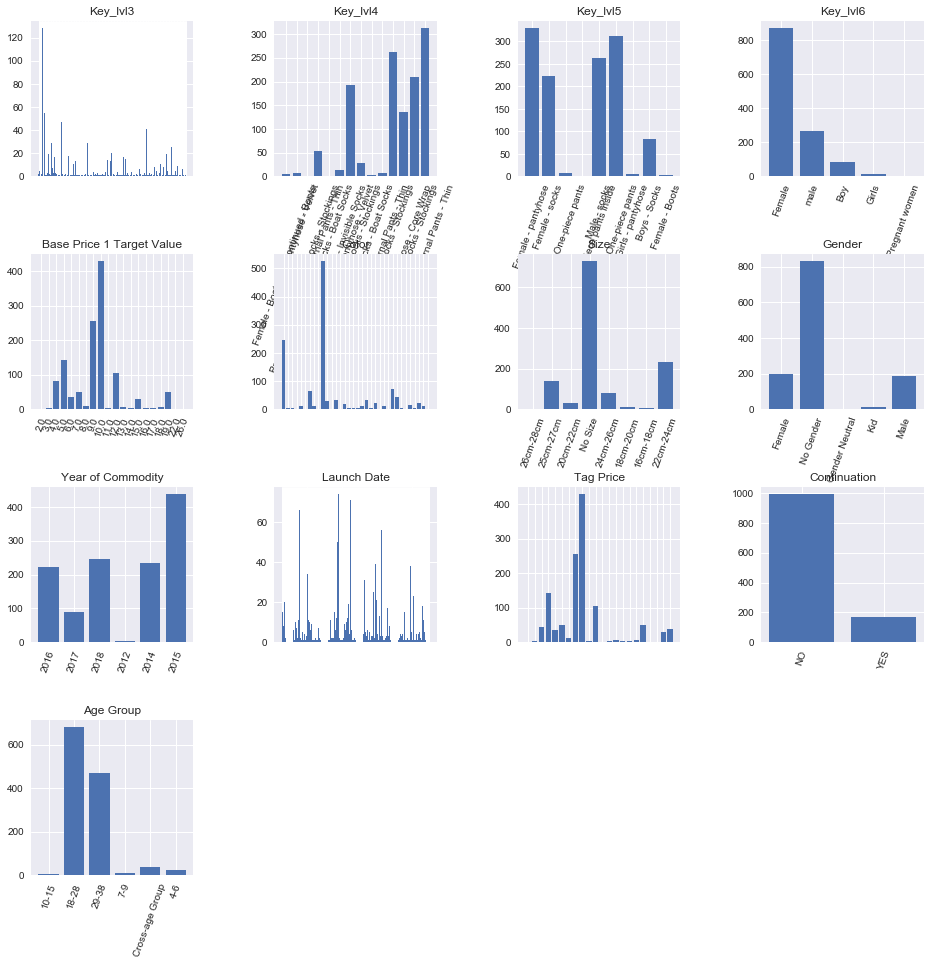

In [211]:
features_df = product_cluster.iloc[:,2:-2]


plt.figure(figsize=(16,20))
features = features_df.columns
for i,f in enumerate(features):
    counts = features_df.groupby([f])[f].count().to_dict()
    dist = list(counts.values())
    keys = list(counts.keys())
    chisq, p = chisquare(dist)
    plt.subplot(5,4,i+1)
    plt.title("%s"%(f))
    plt.bar(range(len(keys)),dist)
    plt.xticks(range(len(keys)),keys,rotation=70)
    if len(keys)>20: plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)      
plt.show()

### Apply MCA on Products

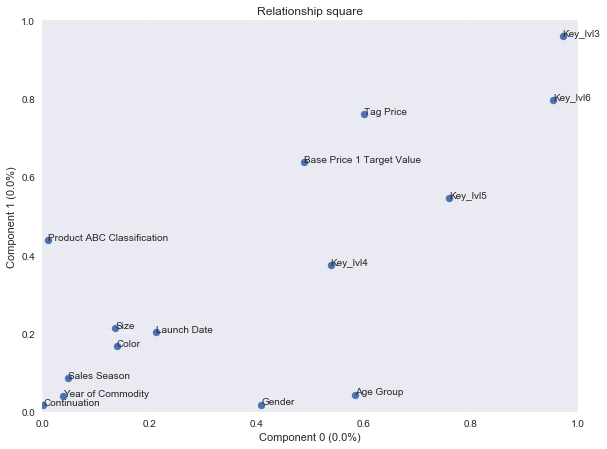

In [148]:
import prince

relevent = ['Key_lvl3', 'Key_lvl4', 'Key_lvl5',
       'Key_lvl6', 'Base Price 1 Target Value', 'Color', 'Size', 'Gender',
       'Year of Commodity', 'Launch Date', 'Tag Price', 'Sales Season',
       'Continuation', 'Age Group', 'Product ABC Classification']

features_df = df_produit[relevent].astype(str).fillna("NA").copy()
#mca = prince.MCA(features_df)
mca.plot_relationship_square()
plt.show()

### Apply MCA on Clients

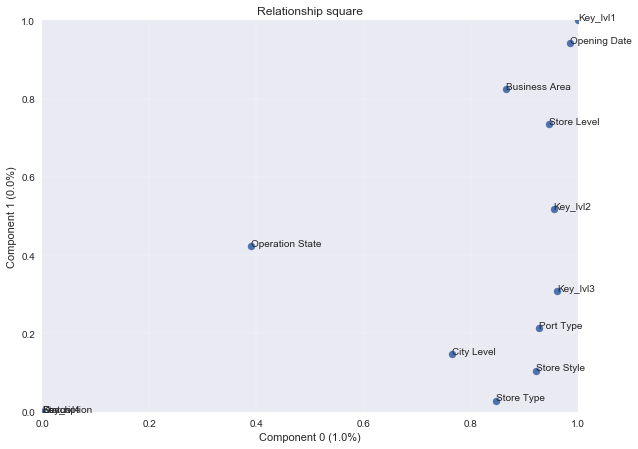

In [144]:
import prince
features_df = client_df.astype(str).fillna("NA")
mca = prince.MCA(features_df)
mca.plot_relationship_square()
plt.show()

## Classification Tree

In [140]:
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier  
import subprocess
from sklearn.tree import  export_graphviz
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder


def visualize_tree(tree, feature_names,class_names=None):
    
    with open(reports_path+"dt.dot", 'w') as f:
        
        export_graphviz(tree, out_file=f, feature_names=feature_names,  filled=True, rounded=True, class_names=True )

    command = ["C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe", "-Tpng", reports_path+"dt.dot", "-o", "dt.png"]
    
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

        
drop =["Key_lvl1","Centroid","Launch Date","Year of Commodity","Description","Gender","Size"]#,"Key_lvl3","Key_lvl4","Key_lvl5","Key_lvl6"
keep = ["Key_lvl3","Key_lvl4","Key_lvl5","Key_lvl6","Cluster"]
                
        
        
data = product_cluster.drop(drop,axis=1).fillna("NA")
data = data[keep]

cat_data = []
i=0
for label,col in data.iteritems():
    cat_data.append(col.astype('category'))
    
df = pd.DataFrame(np.array(cat_data).T,columns = data.columns)

lb = LabelBinarizer()
le = LabelEncoder()

X = pd.get_dummies(data.drop(["Cluster"],axis=1).iloc[:,:].astype(str))
print(X.shape)
display(data.head())
features = X.columns
y = lb.fit_transform(data.values[:,-1].astype(int).T)

(1230, 227)


,Key_lvl3,Key_lvl4,Key_lvl5,Key_lvl6,Cluster
0,Female - One-piece pants inside - Thin - $29,Female - One Internal Pants - Thin,Female - One-piece pants,Female,1
1,Female - One-piece pants inside - Thin - $29,Female - One Internal Pants - Thin,Female - One-piece pants,Female,2
2,Female - One-piece pants inside - Thin - $29,Female - One Internal Pants - Thin,Female - One-piece pants,Female,3
3,Female - One-piece pants inside - Thin - $39,Female - One Internal Pants - Thin,Female - One-piece pants,Female,37
4,Female - One-piece pants inside - Thin - $29,Female - One Internal Pants - Thin,Female - One-piece pants,Female,8


In [194]:
x_data  = data.drop(["Cluster"],axis=1).iloc[:,:].astype(str)
y_data = data.values[:,-1].astype(int)


from sklearn.feature_extraction import DictVectorizer

X_dict = x_data.T.to_dict().values()

vect = DictVectorizer(sparse=False)
X_vector = vect.fit_transform(X_dict)

y = lb.fit_transform(y_data.T)
y = y_data.T
X = X_vector
encoded = np.zeros((x_data.shape))
for j,col in enumerate(x_data.values.T):
    encoded[:,j] = le.fit_transform(col)
    

In [195]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)  

#classifier = DecisionTreeClassifier(criterion = "gini", max_depth=200, min_samples_leaf=4)  
# classifier = SVC(C=2.5,kernel='linear', probability=True,shrinking=True,tol=0.005, verbose=True)
classifier = RandomForestClassifier(n_estimators=50)
# classifier = MLPClassifier(hidden_layer_sizes=(10,5),solver='lbfgs',max_iter=2000,verbose=True,tol = 0.000001)
# classifier = KNeighborsClassifier(n_neighbors=4,weights='uniform', algorithm='brute');


classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)

In [196]:
h = classifier.predict(X_train[0:1])
X_test.shape

(123, 227)

## Evaluation the algorithm

In [199]:
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import precision_recall_fscore_support as report
print(confusion_matrix(y_test, y_pred)) 
precision,recall,fscore,support = report(y_test, y_pred,warn_for=())
print(classification_report(y_test,y_pred ))

[[3 0 1 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
             precision    recall  f1-score   support

          1       0.11      0.20      0.14        15
          2       0.00      0.00      0.00         1
          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00         2
          5       0.00      0.00      0.00         3
          6       0.00      0.00      0.00         1
          7       0.00      0.00      0.00         8
          8       0.00      0.00      0.00         0
          9       0.25      0.33      0.29         6
         10       0.00      0.00      0.00         3
         11       0.00      0.00      0.00         0
         12       0.00      0.00      0.00         1
         13       0.00      0.00      0.00         6
         14       0.00      0.00      0.00         3
         15       0.00      0.00      0.00         3
         16       0.00 

C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rahmim00\AppData\Local\Continuum\anaconda3\envs\dev_py34\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [190]:
imp = np.array(classifier.feature_importances_)
imp_ft = features[np.argsort(imp)[::-1]]
print(imp_ft.values)

['Key_lvl3_Female - One-piece pants inside - Thin - $29'
 'Key_lvl3_Women - Socks - Stockings - $10'
 'Key_lvl3_Men - Socks - Tube Socks - 5 RMB'
 'Key_lvl3_Women - Pantyhose - Velvet - 15 RMB'
 'Key_lvl3_Men - Socks - Stockings - 3.5RMB' 'Key_lvl5_Female - pantyhose'
 'Key_lvl3_Men - Socks - Stockings - $5'
 'Key_lvl3_Women - Pantyhose - Core Material - 19 yuan'
 'Key_lvl3_Women - Socks - Stockings - 3.5 RMB'
 'Key_lvl3_Women - Pantyhose - Velvet - 25 yuan'
 'Key_lvl3_Female - One-piece pants inside - Thin - $79'
 'Key_lvl3_Men - Socks - Stockings - $10'
 'Key_lvl3_Men - socks - stockings -12 yuan'
 'Key_lvl3_Female - One-piece pants inside - Thin - $99'
 'Key_lvl3_Men - Socks - Stockings - 9 yuan'
 'Key_lvl3_Boy - Socks - Stockings - -8 yuan'
 'Key_lvl3_Women - Pantyhose - Core Wrap - 10 yuan'
 'Key_lvl3_Women - Socks - Stockings - 19 yuan'
 'Key_lvl3_Women - Socks - Stockings - 9 yuan'
 'Key_lvl3_Men - Socks - Stockings - 6.5 RMB'
 'Key_lvl3_Female - One-piece pants inside - Thin 9 

In [414]:
from graphviz import Graph,Source
from IPython.display import SVG

graph = Source(export_graphviz(classifier, out_file=None
   , feature_names=features, class_names=True
   , filled = True))

display(SVG(graph.pipe(format='svg')))


AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'